# We have the problem that wind forcing seems to dominate changes to modal decomposition, rather than topo shape!

## In this notebook, compare the same time slices over 100hr average. Focus on mode 1. Make movies maybe?

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:41121' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41121,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:32937,Total threads: 4
Dashboard: /proxy/40717/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34183,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [2]:
trange = 50
to_process = {
    "full-20": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    # "blank-20": {
        # "data":tt.collect_data(
            # exptname="blank-20",
            # rawdata = ["rho","u","v"],
            # timerange = (1000 - trange,1000 + trange)
        # ).sel(yb = slice(-50,50))
    # },
    "ideal-20": {
        "data":tt.collect_data(
            exptname="ideal-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50)),
    },
    # "smooth-20": {
        # "data":tt.collect_data(
            # exptname="smooth-20",
            # rawdata = ["rho"],
            # lfiltered = "10000-lowpass"
        # ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        # },
    }

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/120892833.gadi-pbs/ipykernel_2773238/3646734636.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


loading rho...	done.
loading u...	done.
loading v...	done.


In [3]:
## Load in the eigenfunctions

to_process["full-20"]["efuncs"] = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/full-20/vertical_modes_fulldom.nc")
to_process["ideal-20"]["efuncs"] = tt.ShootingVmodes(
    xr.merge(
        [
            to_process["ideal-20"]["data"].bathy.rename("H"),
            tt.getN(to_process["ideal-20"]["data"].rho).rename("N").mean("time")
        ]).sel(xb = slice(400,405),yb = slice(0,5)).load().chunk({"xb":1,"yb":1})
)


In [4]:
to_process["full-20"]["U"]  = (to_process["full-20"]["efuncs"].U * to_process["full-20"]["data"].u).fillna(0).integrate("zl").load() 
to_process["full-20"]["V"]  = (to_process["full-20"]["efuncs"].U * to_process["full-20"]["data"].v).fillna(0).integrate("zl").load() 
to_process["ideal-20"]["U"] = (to_process["ideal-20"]["efuncs"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * to_process["ideal-20"]["data"].u).fillna(0).integrate("zl").load() 
to_process["ideal-20"]["V"] = (to_process["ideal-20"]["efuncs"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * to_process["ideal-20"]["data"].v).fillna(0).integrate("zl").load() 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 35.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 35.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/jobfs/120892833.gadi-pbs/ipykernel_2773238/3608750514.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  to_process["ideal-20"]["U"] = (to_process["ideal-20"]["efuncs"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * to_process["ideal-20"]["data"].u).fillna(0).integrate("zl").load()
/jobfs/120892833.gadi-pbs/ipykernel_2773238/3608750514.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.

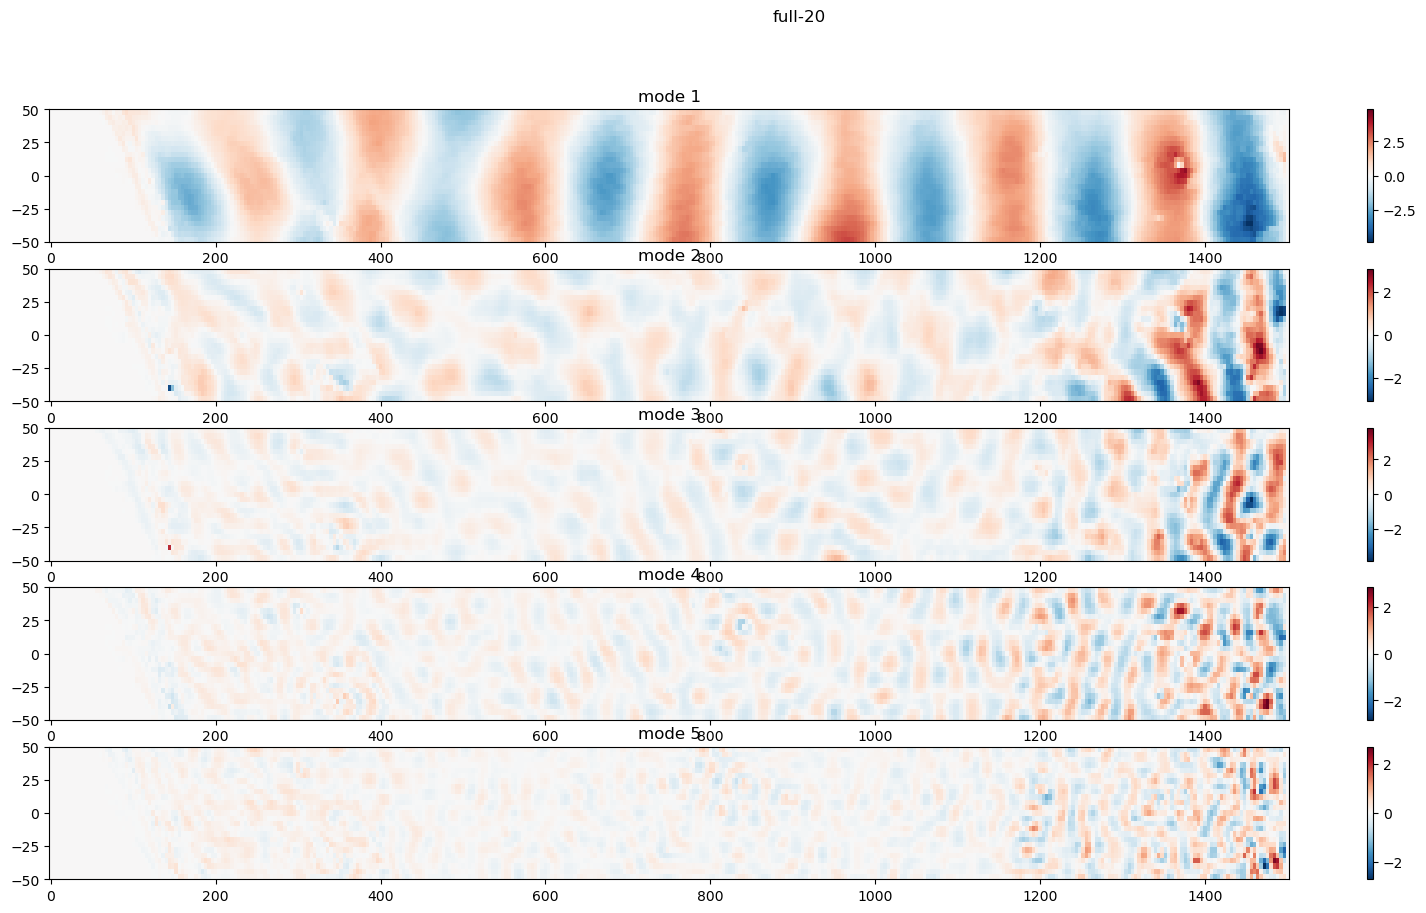

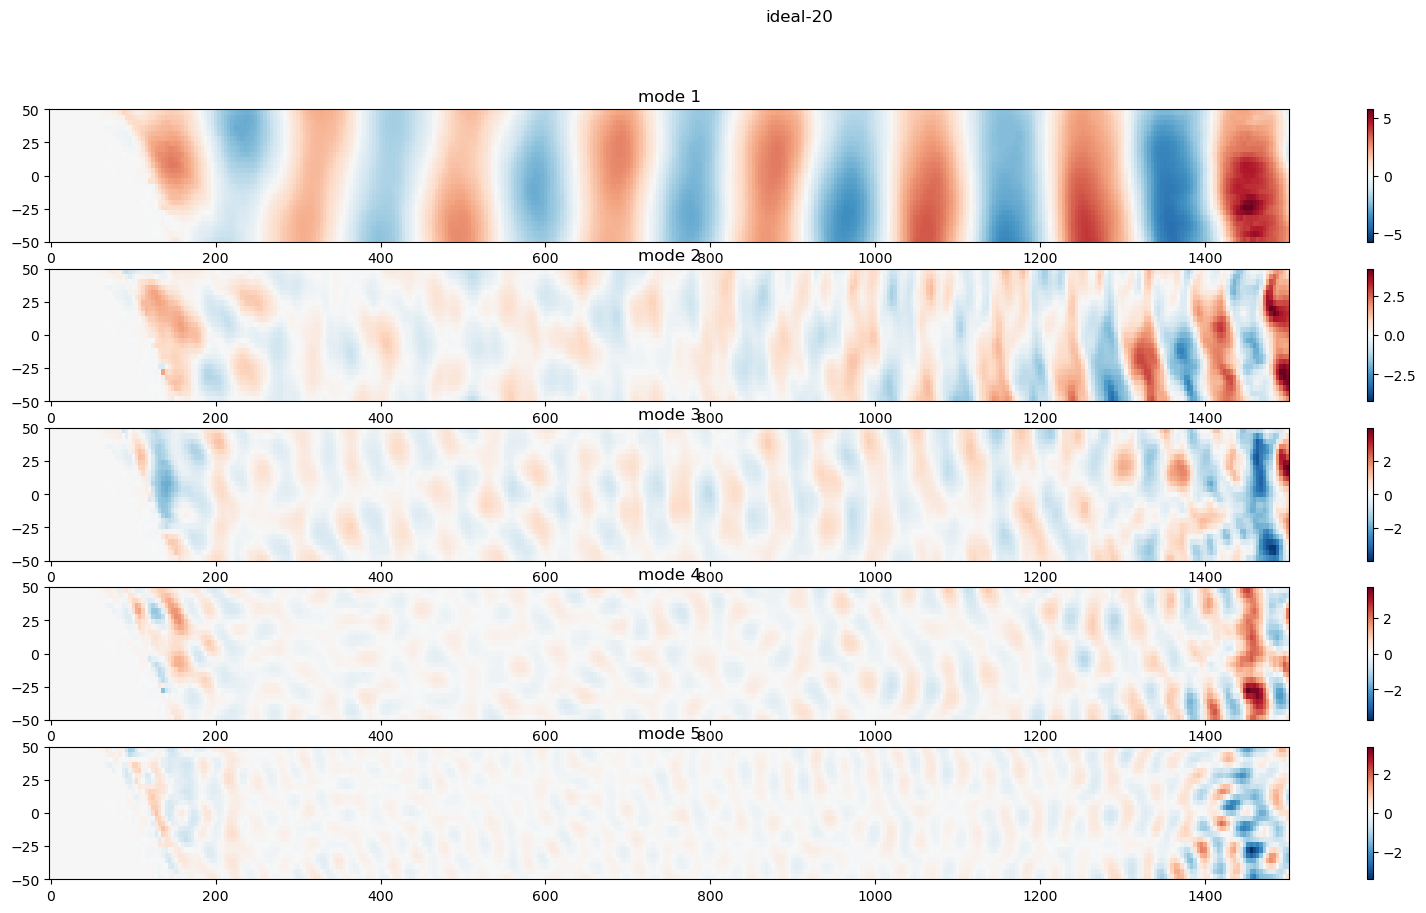

In [63]:

for expt in to_process:
    vmodes = to_process[expt]["vmodes"]
    fig,ax = plt.subplots(5,figsize = (20,10))

    for mode in range(len(vmodes.mode)):
        fig.suptitle(expt)
        vmodes.isel(time = 50,mode = mode).plot(ax = ax[mode])    
        ax[mode].set_xlabel("")
        ax[mode].set_ylabel("")
        ax[mode].set_title(f"mode {mode + 1}")


/jobfs/120872962.gadi-pbs/ipykernel_2770052/2718548773.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data.drop(['lon', 'lat']).sel(xb = slice(200,1200)),dim = ["time","xb"]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default iff

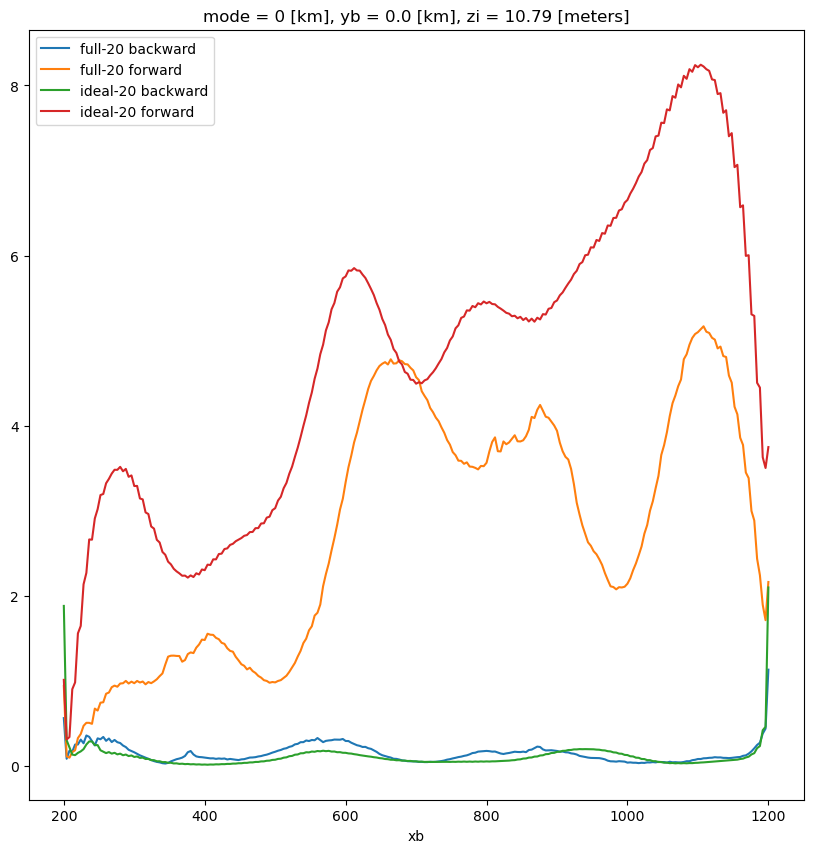

In [17]:
fig,ax = plt.subplots(1,figsize = (10,10))
def DirectionalFilter(data):
    """
    Fourier filter into forward and backward propagating signals
    """
    import xrft
    FT = xrft.fft(
        data.drop(['lon', 'lat']).sel(xb = slice(200,1200)),dim = ["time","xb"]
    ).load()

    ft = np.real(xrft.ifft(
        FT,dim = ["freq_time","freq_xb"]
    ))

    forward = np.real(xrft.ifft(
        FT.where((FT.freq_xb >= 0) & (FT.freq_time >= 0), 0) + FT.where((FT.freq_xb <= 0) & (FT.freq_time <= 0), 0) - FT.where((FT.freq_xb == 0) & (FT.freq_time == 0), 0),
        dim = ["freq_time","freq_xb"]
    ))

    backward = np.real(xrft.ifft(
        FT.where((FT.freq_xb <= 0) & (FT.freq_time >= 0), 0) + FT.where((FT.freq_xb >= 0) & (FT.freq_time <= 0), 0) - FT.where((FT.freq_xb == 0) & (FT.freq_time == 0), 0),
        dim = ["freq_time","freq_xb"]
    ))

    return xr.merge([forward.rename(f"{data.name}_forward"),backward.rename(f"{data.name}_backward")])
for expt in ["full-20","ideal-20"]:
    uFiltered = DirectionalFilter(to_process[expt]["U"].rename("u").isel(mode = 0))
    vFiltered = DirectionalFilter(to_process[expt]["V"].rename("v").isel(mode = 0))

    ke_forward = (uFiltered.u_forward**2 + vFiltered.v_forward**2).mean("time").sel(yb = 0,method = "nearest")
    ke_backward = (uFiltered.u_backward**2 + vFiltered.v_backward**2).mean("time").sel(yb = 0,method = "nearest")

    ke_backward.plot(ax = ax,label = f"{expt} backward")
    ke_forward.plot(ax = ax,label = f"{expt} forward")
    ax.legend()

## Check general conservation of energy:

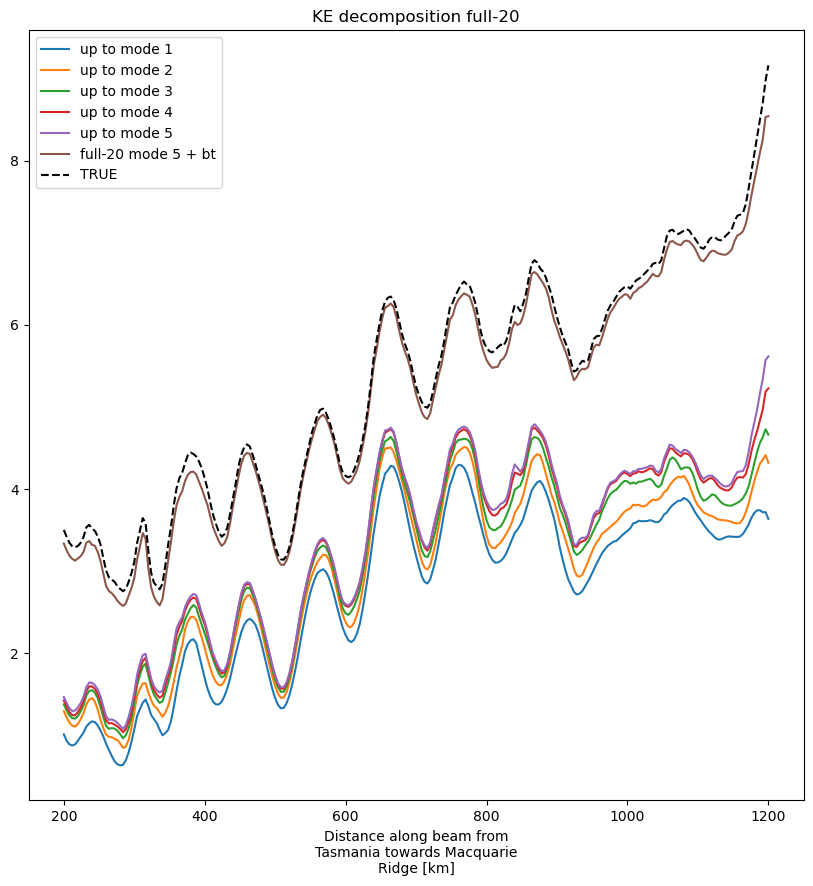

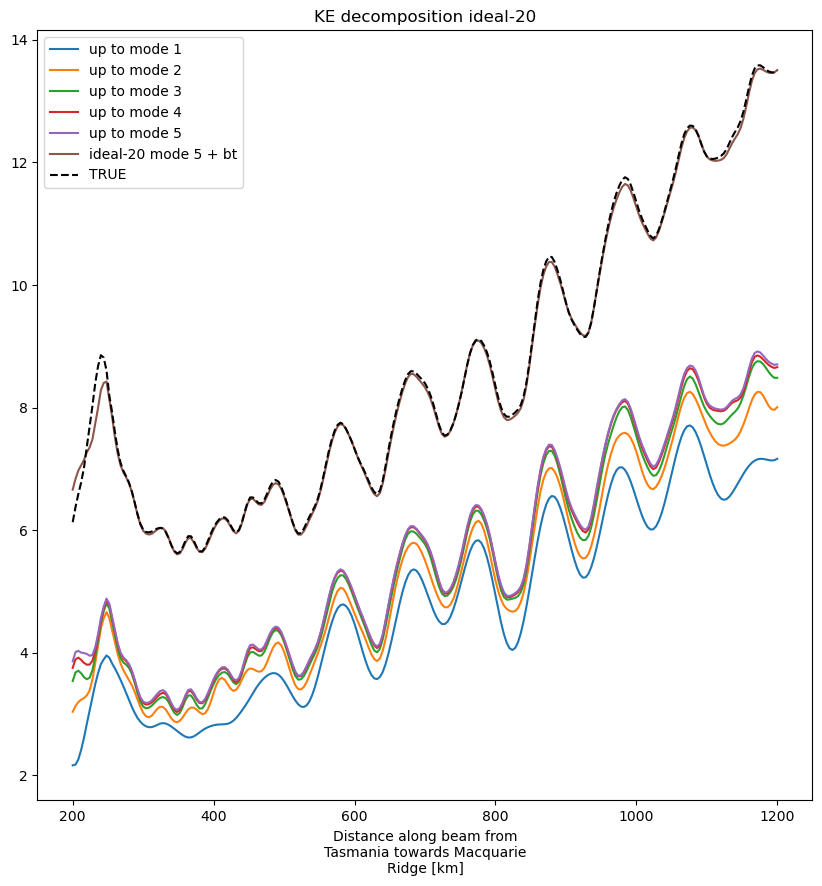

In [14]:
# def getBT(data):

for expt in ["full-20","ideal-20"]:
    fig,ax = plt.subplots(1,figsize = (10,10))

    ke = (to_process[expt]["U"]**2 + to_process[expt]["V"]**2).mean("yb").mean("time").cumsum("mode")
    ke_true = (to_process[expt]["data"].u.fillna(0)**2 + to_process[expt]["data"].v.fillna(0)**2).mean("yb").mean("time").integrate("zl")
    H = np.abs(to_process[expt]["data"].bathy)
    ubt = to_process[expt]["data"].u.fillna(0).integrate("zl")/H
    vbt = to_process[expt]["data"].v.fillna(0).integrate("zl")/H

    ke_bt = ((ubt**2 + vbt**2) * H).mean("yb").mean("time")

    # ke_bt = ((to_process[expt]["data"].u.integrate("zl")/to_process[expt]["data"].bathy)**2 + (to_process[expt]["data"].v.integrate("zl")/to_process[expt]["data"].bathy)**2).mean("yb").mean("time")

    for i in range(5):
        ke.isel(mode = i).sel(xb = slice(200,1200)).plot(ax = ax,label = f"up to mode {1+ i}")

    (ke.isel(mode = -1) + ke_bt).sel(xb = slice(200,1200)).plot(ax = ax,label = f"{expt} mode 5 + bt")
    ke_true.sel(xb = slice(200,1200)).plot(ax = ax,color = "black",linestyle = "--",label = "TRUE")
    ax.set_xlim
    ax.legend()
    ax.set_title(f"KE decomposition {expt}")

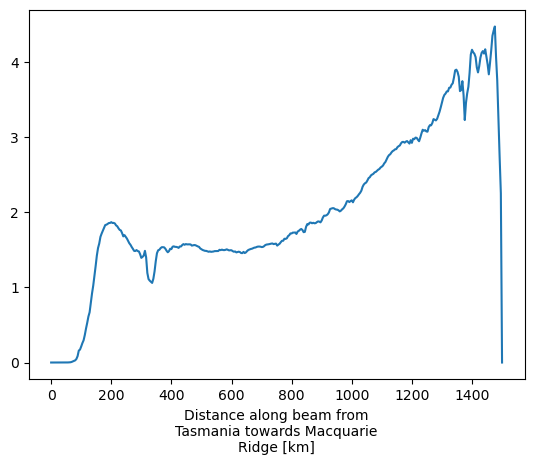

In [49]:
expt = "full-20"
u_bt = to_process[expt]["data"].u.fillna(0).integrate("zl")
v_bt = to_process[expt]["data"].v.fillna(0).integrate("zl")

u_bt_normalised = u_bt / to_process[expt]["data"].bathy
v_bt_normalised = v_bt / to_process[expt]["data"].bathy

((u_bt_normalised**2 + v_bt_normalised**2) * (-1) * to_process[expt]["data"].bathy).mean("yb").mean("time").plot()

In [14]:
def vmodes(expt,t0 = 10000):
    client = tt.startdask()
    print(client)
    tt.logmsg("Starting vertical modes calculation")
    try:
        data = tt.collect_data(
                exptname=expt,
                rawdata = ["rho"],
                timerange = (t0,t0 + 10000)
            ).sel(yb = slice(-5,5))
    except:
        data = tt.collect_data(
            exptname=expt,
            rawdata = ["rho"],
            timerange = (t0,t0 + 4000)
        ).sel(yb = slice(-5,5))
    if "zi" in data:
        data = data.drop_vars("zi")
    H = data.bathy
    if H.mean("xb").mean("yb") <= 0:
        H *= -1

    N = tt.getN(data.rho).mean("time").load()

    data = xr.merge([N.rename("N"),H.rename("H")]).load()
    data = data.chunk({"xb":1,"yb":1,"zl":-1})

    tt.logmsg("Calculating vertical modes")
    out = tt.ShootingVmodes_parallel(data,nmodes = 5).load()
    tt.logmsg("success")

    out.to_netcdf(f"/g/data/nm03/ab8992/postprocessed/{expt}/VerticalEigenfunctions.nc")

    return

N = vmodes("smooth-20",t0 = 10000)

<Client: 'tcp://127.0.0.1:33363' processes=7 threads=28, memory=112.00 GiB>
<Client: 'tcp://127.0.0.1:33363' processes=7 threads=28, memory=112.00 GiB>
loading rho...	done.


2024-07-16 11:28:57,566 - distributed.worker - WARNING - Compute Failed
Key:       ('ShootingVmodes-030dc1474e30a08ef8286bef28559d58', 2, 0, 0)
State:     executing
Function:  execute_task
args:      ((<function map_blocks.<locals>._wrapper at 0x14cc36cf8ee0>, <function ShootingVmodes at 0x14cc373083a0>, [(<class 'xarray.core.dataset.Dataset'>, (<class 'dict'>, [['N', (('zl', 'yb', 'xb'), array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],



ValueError: index must be monotonic increasing or decreasing

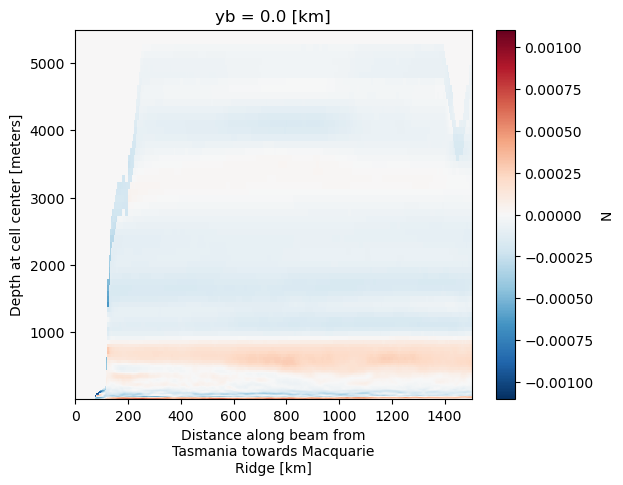

In [11]:
N.diff("zl").isel(yb = 1).plot()

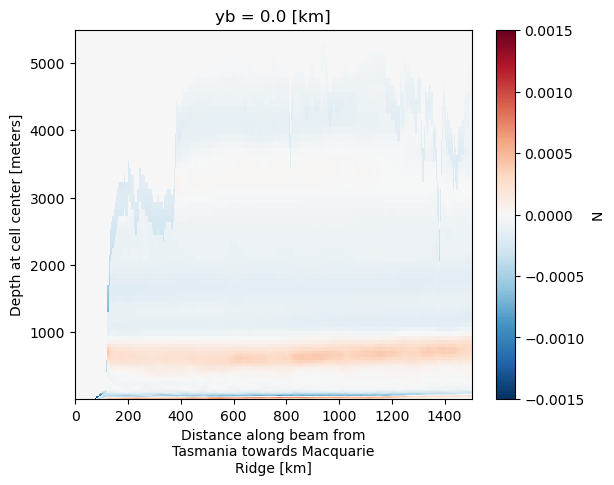

In [13]:
N.diff("zl").isel(yb = 1).plot()


In [ ]:
efuncs = xr.open_dataset(f"/g/data/nm03/ab8992/postprocessed/smooth-20/VerticalEigenfunctions.nc")

efuncs.U.isel(mode = 0).plot()

In [8]:
a = np.array([1,2,3,4,3,6,7])
if np.all(np.diff(a) > 0):
    print("True")

In [ ]:
fig,ax = plt.subplots(5,figsize = (10,10))

for expt in to_process:
    vmodes = to_process[expt]["vmodes"]

    for mode in range(len(vmodes.mode)):
        ((vmodes.isel(mode = mode)**2).integrate("time").integrate("yb")).plot(ax = ax[mode],label = expt)    
        ax[mode].legend()


: 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowd

Text(0.5, 0, '<-- Tassie  (km)  Macquarie Ridge -->')

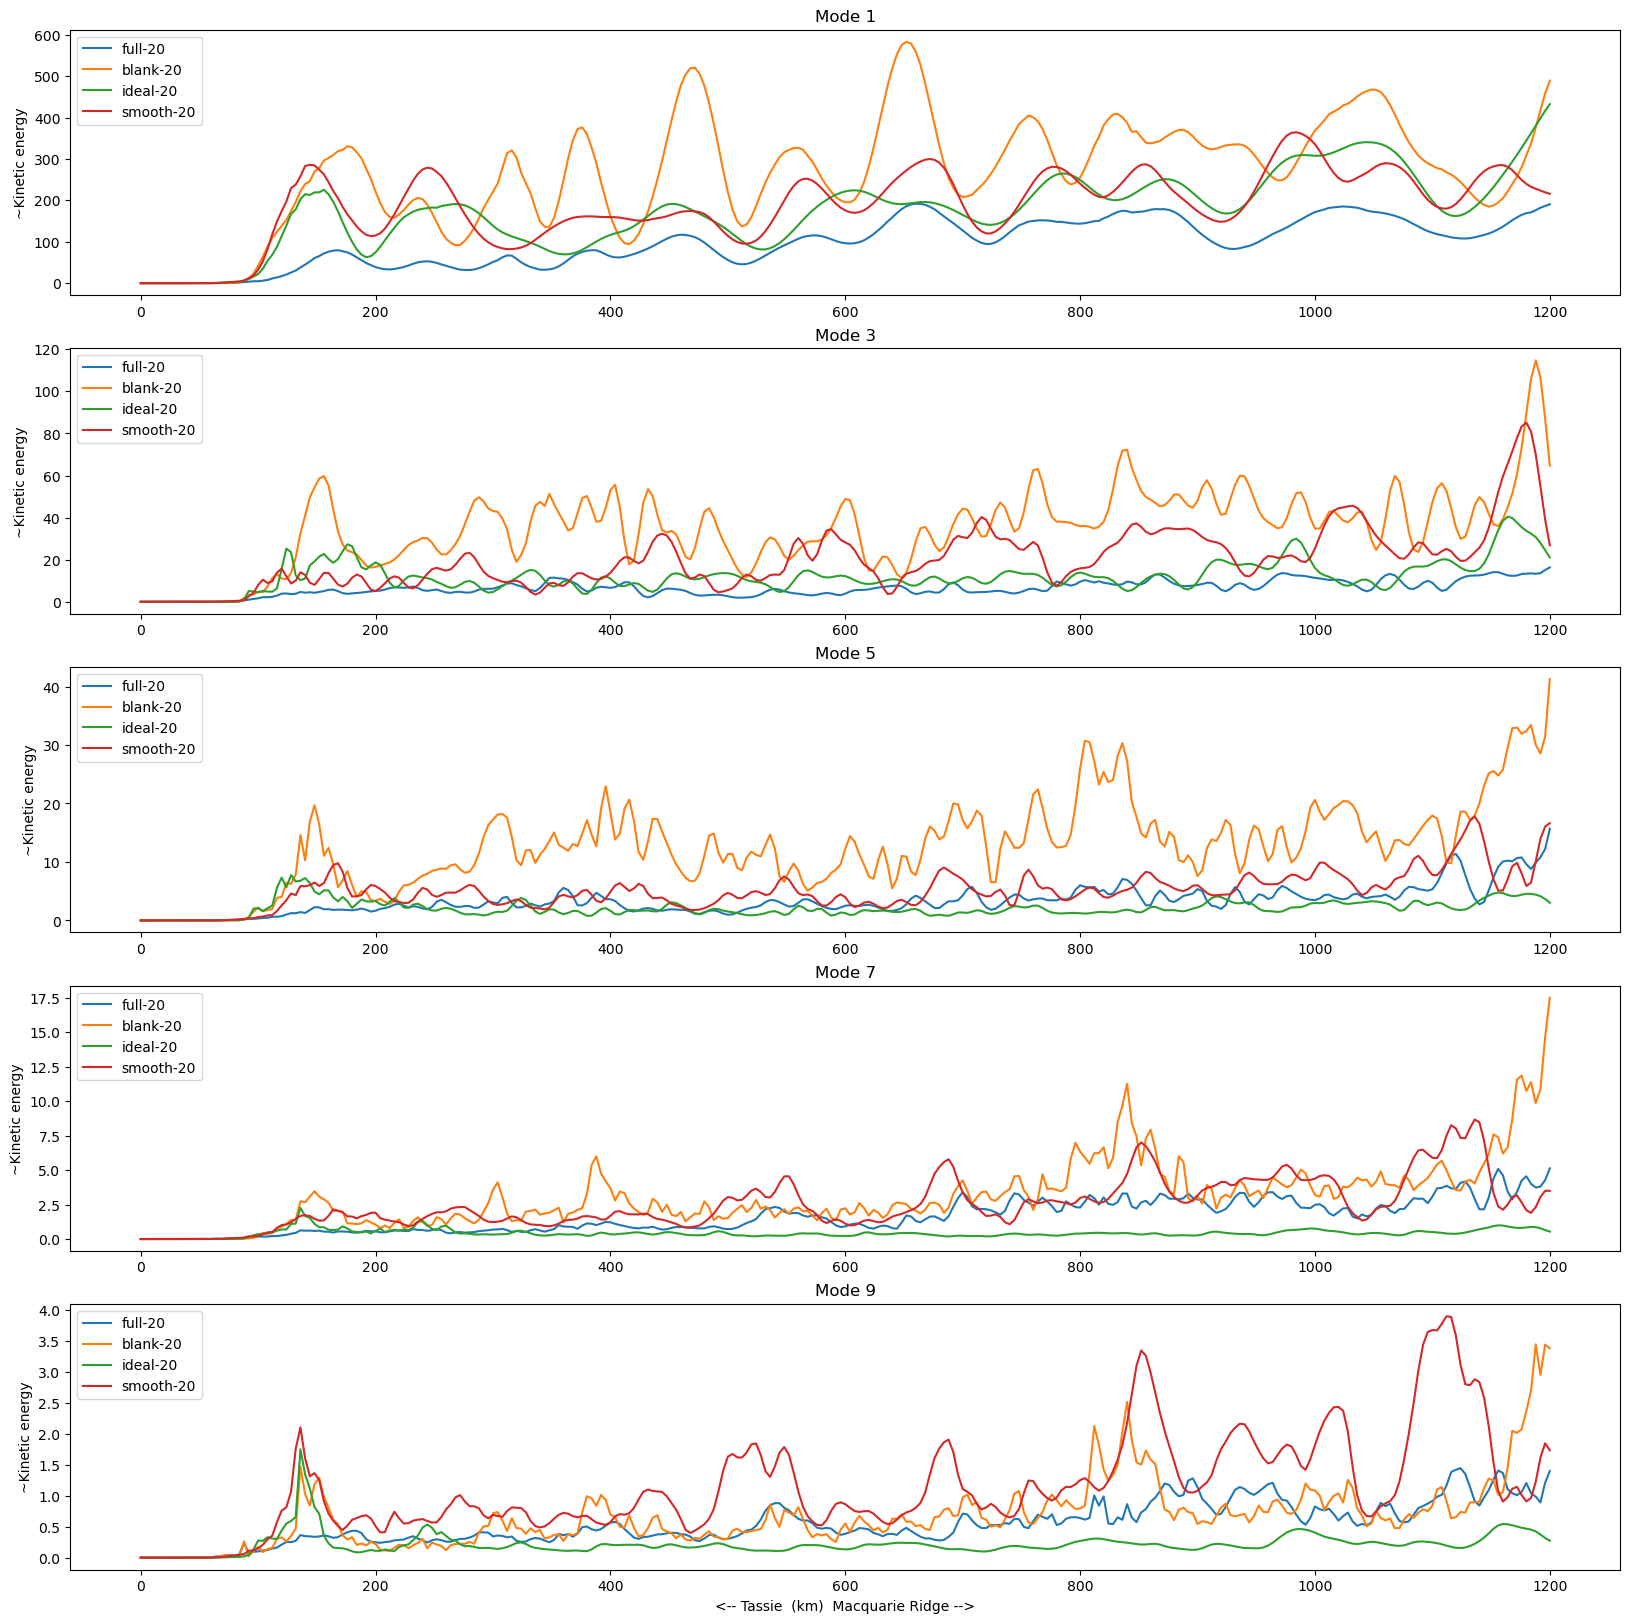

In [19]:
fig,ax = plt.subplots(5,figsize = (20,20))

for expt in to_process:
    for i,mode in enumerate(range(1,10,2)):
        to_process[expt]["KE"].mean("time").integrate("yb").isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i],label = expt)

        ax[i].set_title(f"Mode {mode}")


        ax[i].legend()
        ax[i].set_ylabel("~Kinetic energy")
        ax[i].set_xlabel("")



ax[-1].set_xlabel("<-- Tassie  (km)  Macquarie Ridge -->")


In [17]:
for expt in to_process:
    print(expt)
    u = tt.VerticalModes(to_process[expt]["data"],"u").hztl
    v = tt.VerticalModes(to_process[expt]["data"],"v").hztl

    ## Now calculate the KE and integrate in time
    KE = 0.5 * ((u**2 + v**2))
    to_process[expt]["KE"] = KE


full-20
blank-20
ideal-20
smooth-20


# Vertical Mode Movie



In [ ]:
vmodes = VerticalModes(to_process["full-20"]["data"]).load()


In [4]:
def PlotForMovie(data):
    fig,ax = plt.subplots(5,2,figsize = (20,20))

    for i in range(len(data.mode)):

        data["u"].isel(mode = i).sel(xb = slice(0,1200)).plot(ax = ax[i,0])
        data["v"].isel(mode = i).sel(xb = slice(0,1200)).plot(ax = ax[i,1])
        tt.plot_topo(ax[i,0])
        tt.plot_topo(ax[i,1])
        ax[i,0].set_xlim(0,1200)
        ax[i,1].set_xlim(0,1200)
        ax[i,0].set_title("")
        ax[i,1].set_title("")
        ax[i,0].set_xlabel("")
        ax[i,1].set_ylabel("Mode: " + str(i + 1))
        ax[i,1].set_xlabel("")
        ax[i,0].set_ylabel("Distance to beam centre (km)")

    ax[-1,0].set_xlabel("Distance from Tas (km)")
    ax[-1,1].set_xlabel("Distance from Tas (km)")
        
    return fig

# fig = PlotForMovie(vmodes.isel(time = 50))

# tt.make_movie(
#     vmodes,
#     PlotForMovie,
#     "full-20",
#     "vertical_modes"
# )


In [5]:
# for d in ["full-20","smooth-20"]:
for d in ["smooth-20"]:
    data = tt.collect_data(
            exptname=d,
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).drop("cst").chunk({"zl":-1}).sel(xb = slice(0,1200)).persist()
    tt.make_movie(
        VerticalModes(data).load(),
        PlotForMovie,
        d,
        "vertical_modes_fulldomain"
    )

    

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/118778567.gadi-pbs/ipykernel_1919365/479221704.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).drop("cst").chunk({"zl":-1}).sel(xb = slice(0,1200)).persist()
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data

2024-06-21 10:06:57,576 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-u-856d072b98cb891f58f5f62fa3ea6bf6' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x151dc537add0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x151cdcb423c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x151dc537add0>, (ImplicitToExplicitIndexingAdapte

Making movie vertical_modes_fulldomain for smooth-20
/g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes_fulldomain
ffmpeg -r 5  -i /g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes_fulldomain/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p /g/data/v45/ab8992/dropbox/tasman-tides/smooth-20/moviesvertical_modes_fulldomain.mp4
ffmpeg finished with returncode 0 

 and output 


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmp

In [ ]:
trange = 50

for d in ["blank-20","ideal-20"]:
    data = tt.collect_data(
            exptname=d,
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange).chunk({"zl":-1,"time":10}).sel(xb = slice(0,1200)).persist()
    )
    tt.make_movie(
        VerticalModes(data).load(),
        PlotForMovie,
        d,
        "vertical_modes_fulldomain"
    )
